In [1]:
import warnings
warnings.simplefilter(action='ignore')

import seaborn as sns 
import numpy as np
import pandas as pd 
import pathlib
import json 
from matplotlib import pyplot as plt 
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 18, 'lines.markeredgewidth': 5})
# sns.set_style(style='ticks')


# color scheme
color_mapping = {"baseline": "#ca0020", "no source": "#0571b0", "group DRO": "#f4a582", "upsample": "#e6550d" }

# marker_lookup = {'baseline'play_radio': "d", "FindManager": "o", 'email_query': "H", "Tomorrow": "P", 'email_querycontact': "^", "PlaceHasFeature": ">", 'general_quirky': "s", "DoNotConfirm": "p", 'traffic': "8", "FenceAttendee": "*", "total": "D"}

marker_lookup = {"baseline": "d", "no source": "o", "upsample": "^", "group DRO": "s"}


In [15]:
name_lookup = {"valid_em": "Exact Match", "valid_coarse": "Coarse", "valid_fine": "Fine", "valid_precision": "Precision", 
               "test_em": "Exact Match", "test_coarse": "Coarse", "test_fine": "Fine", "test_precision": "Precision"}

setting_lookup = {"5000": "5k", "10000": "10k", "20000": "20k", "50000": "50k", "100000": "100k",
                  "750": "0.75k", "1500": "1.5k", "3000": "3k", "7500": "7.5k", "15000": "15k", "18000": "max"}

def plot_calflow(paths_and_fxns,
                title, 
                savepath=None, 
                fixed_axis=False, 
                prefix="valid", 
                xs = ["5000","10000","20000","50000","100000","max"], 
                ax = None, 
                use_total=True, 
                use_coarse=False, 
                add_nums=False, 
                hue_var="type",
                ymin = None, 
                ymax=None,
                show_legend=False,
                legend_kws={}):

    df = pd.DataFrame(columns=['fxn', 'train', 'examples', 'seed', 'acc', 'type'], dtype=object)
    for fxn, path, type_name in paths_and_fxns:
        single_df = pd.read_csv(path, index_col=0)
        single_df = single_df[single_df['function'] == 100]
        if type_name == "total": 
            col_names = ['train', 'function', 'seed', 'test_em']
        else:
            col_names = ['train', 'function', 'seed', 'test_fine']
        single_df = single_df[col_names]

        single_df = single_df.rename(columns={"function": "examples", "seed": "seed", "train": "train", "test_fine": "acc", "total": "acc"})
        single_df['fxn'] = [fxn for i in range(len(single_df))]
        single_df['type'] = [type_name for i in range(len(single_df))]
        df = df.append(single_df, ignore_index=True)

    if ax is None:
        fig, ax = plt.subplots()

    sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 
    sns.lineplot(data=df, 
                x="train", 
                y="acc",  
                hue=hue_var, 
                err_style='band', 
                style = hue_var, 
                markers=marker_lookup,
                dashes=False,
                markersize=7,
                linewidth=3,
                ax=ax, 
                palette=color_mapping)
                
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 

    if ymin is not None:
        ax.set_ylim(bottom=ymin)
    if ymax is not None:
        ax.set_ylim(top=ymax)

    # labels = ax.get_xticklabels()
    # ax.set_xticklabels([setting_lookup[lab] for lab in labels])
    ax.set_xticklabels(['5k', '10k', '20k', '50k', '100k', 'max'])
    # sns.set(font_scale = 1.1)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel("Total Training Examples")

    if show_legend: 
        ax.legend(**legend_kws)
    else:
        ax.legend([], [], frameon=False)

    if savepath is not None:
        plt.tight_layout()
        plt.savefig(savepath)



In [3]:

def get_data_from_dir(root_data_dirs_and_settings, fxn, seeds):
    all_data = pd.DataFrame(columns=["train", "function", "seed", "type", "total_acc", f"{fxn}_acc", "intent"], dtype=object)
    for root_data_dir, type_name in root_data_dirs_and_settings:
        root_data_dir = pathlib.Path(root_data_dir).joinpath(str(fxn))
        for seed in seeds:
            data_dir = root_data_dir.joinpath(f"{seed}_seed")
            globs = [x for x in data_dir.glob("*/test_metrics.json")]
            globs = sorted(globs, key = lambda x: int(x.parent.name.split("_")[0]))

            for path in globs:
                try:
                    data = json.load(open(path))
                except json.JSONDecodeError:
                    data = {}
                    data['acc'] = np.nan
                    data[f'{fxn}_acc'] = np.nan

                setting = path.parent.name
                num_train, num_fxn = setting.split("_")
                num_train, num_fxn = int(num_train), int(num_fxn)

                to_add = {"train": str(num_train), "function": num_fxn, "seed": seed, "type": type_name, 
                        "total_acc": data['acc'] * 100, "intent": fxn, f"{fxn}_acc": data[f"{fxn}_acc"] * 100}
                all_data = all_data.append(to_add, ignore_index=True)

    return all_data 

name_mapping = {"50": "play_radio", "66": "traffic", "15": "email_query", "16": "email_querycontact", "27": "general_quirky"}
def plot_intent(data_dirs, 
                intent, 
                seeds = [12, 31, 64], 
                title=None, 
                savepath=None, 
                fixed_axis=False, 
                xs = [750, 1500, 3000, 7500, 15000, 18000], 
                ax = None, 
                fxn_split = 15,
                axis_title = None,
                show_legend=False, 
                legend_kws = {}):

    data = get_data_from_dir(data_dirs, intent, seeds)
    data = get_data_from_dir(data_dirs, intent, seeds)
    data = data[data['function'] == fxn_split]
    col_names = ["train", "seed", f"{intent}_acc", "type"]
    minor_data = data[col_names]
    minor_data = minor_data.rename(columns={"train": "train", 
                                    f"{intent}_acc": name_mapping[str(intent)]})
    if ax is None:
        fig, ax = plt.subplots()

    sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 
    sns.lineplot(data=minor_data, 
                x="train", 
                y=name_mapping[str(intent)],  
                hue="type", 
                err_style='band',
                markers=marker_lookup,
                style="type",
                dashes=False,
                markersize=7,
                linewidth=3,
                ax=ax, 
                palette=color_mapping)
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    sns.set_theme(font_scale = 1.1, style="ticks", context = "paper") 

    ax.set_title(title, fontsize=14)
    ax.set_ylabel("")

    if axis_title is not None:
        ax.set_xlabel("Total Training Examples")
    else:
        ax.set_xlabel("") 

    # labels = ax.get_xticklabels()
    ax.set_xticklabels(['0.75k', '1.5k', '3k', '7.5k', '15k', 'max'])
    if show_legend:
        ax.legend(**legend_kws)
    else:
        ax.legend([], [], frameon=False)

    if savepath is not None:
        plt.tight_layout()
        plt.savefig(savepath)

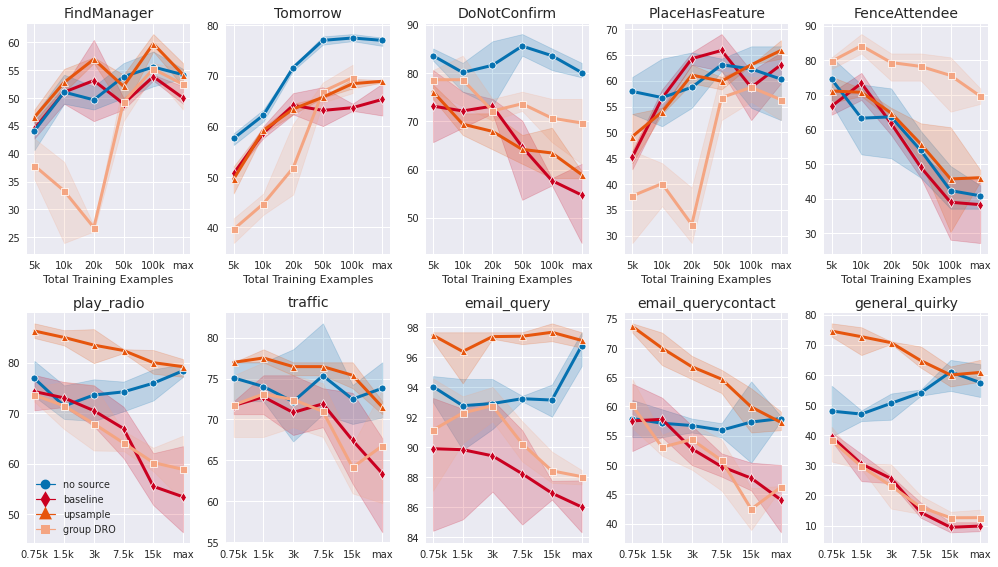

In [4]:
fm_baseline_path = "~/papers/incremental_function_learning/results/FindManager_transformer_test.csv"
fm_no_source_path = "~/papers/incremental_function_learning/results/no_source/FindManager_transformer_no_source.csv"
fm_dro_path = "~/papers/incremental_function_learning/results/group_dro/FindManager_transformer_group_dro.csv"
fm_upsample_path = "~/papers/incremental_function_learning/results/upsample/FindManager_upsample_32.csv"
fm_paths_and_fxns = [("FindManager", fm_baseline_path, "baseline"), 
                     ("FindManager", fm_no_source_path, "no source"), 
                     ("FindManager", fm_dro_path, "group DRO"),
                     ("FindManager", fm_upsample_path, "upsample")]


tom_baseline_path = "~/papers/incremental_function_learning/results/Tomorrow_transformer_test.csv"
tom_no_source_path = "~/papers/incremental_function_learning/results/no_source/Tomorrow_transformer_no_source.csv"
tom_dro_path = "~/papers/incremental_function_learning/results/group_dro/Tomorrow_transformer_group_dro.csv"
tom_upsample_path = "~/papers/incremental_function_learning/results/upsample/Tomorrow_upsample_32.csv"
tom_paths_and_fxns = [("Tomorrow", tom_baseline_path, "baseline"), 
                      ("Tomorrow", tom_no_source_path, "no source"), 
                      ("Tomorrow", tom_dro_path, "group DRO"),  
                      ("Tomorrow", tom_upsample_path, "upsample")]

dnc_baseline_path = "~/papers/incremental_function_learning/results/DoNotConfirm_transformer_full_test.csv"
dnc_no_source_path = "~/papers/incremental_function_learning/results/no_source/DoNotConfirm_transformer_no_source.csv"
dnc_dro_path = "~/papers/incremental_function_learning/results/group_dro/DoNotConfirm_transformer_group_dro.csv"
dnc_upsample_path = "~/papers/incremental_function_learning/results/upsample/DoNotConfirm_upsample_32.csv"
dnc_paths_and_fxns = [("DoNotConfirm", dnc_baseline_path, "baseline"), 
                      ("DoNotConfirm", dnc_no_source_path, "no source"), 
                      ("DoNotConfirm", dnc_dro_path, "group DRO"), 
                      ("DoNotConfirm", dnc_upsample_path, "upsample")]

phf_baseline_path = "~/papers/incremental_function_learning/results/PlaceHasFeature_transformer_test.csv"
phf_no_source_path = "~/papers/incremental_function_learning/results/no_source/PlaceHasFeature_transformer_no_source.csv"
phf_dro_path = "~/papers/incremental_function_learning/results/group_dro/PlaceHasFeature_transformer_group_dro.csv"
phf_upsample_path = "~/papers/incremental_function_learning/results/upsample/PlaceHasFeature_upsample_32.csv"
phf_paths_and_fxns = [("PlaceHasFeature", phf_baseline_path, "baseline"), 
                      ("PlaceHasFeature", phf_no_source_path, "no source"), 
                      ("PlaceHasFeature", phf_dro_path, "group DRO"),
                      ("PlaceHasFeature", phf_upsample_path, "upsample")]

fa_baseline_path = "~/papers/incremental_function_learning/results/FenceAttendee_transformer_test.csv"
fa_no_source_path = "~/papers/incremental_function_learning/results/no_source/FenceAttendee_transformer_no_source.csv"
fa_dro_path = "~/papers/incremental_function_learning/results/group_dro/FenceAttendee_transformer_group_dro.csv"
fa_upsample_path = "~/papers/incremental_function_learning/results/upsample/FenceAttendee_upsample_32.csv"
fa_paths_and_fxns = [("FenceAttendee", fa_baseline_path, "baseline"), 
                     ("FenceAttendee", fa_no_source_path, "no source"), 
                     ("FenceAttendee", fa_dro_path, "group DRO"),
                     ("FenceAttendee", fa_upsample_path, "upsample")]


all_paths = {"FindManager": fm_paths_and_fxns, "Tomorrow": tom_paths_and_fxns, "DoNotConfirm": dnc_paths_and_fxns, "PlaceHasFeature": phf_paths_and_fxns, "FenceAttendee": fa_paths_and_fxns}

fig, ax = plt.subplots(2, 5, figsize=(14, 8), sharex=False, sharey=False)
for i, fxn in enumerate(["FindManager", "Tomorrow", "DoNotConfirm", "PlaceHasFeature", "FenceAttendee"]): 
    plot_calflow(all_paths[fxn], fxn, show_legend=False, ax=ax[0,i])

data_dirs = [("/brtx/606-nvme1/estengel/intent_fixed_test/intent_no_source_manual/", "no source"), 
             ("/brtx/603-nvme1/estengel/intent_fixed_test/intent/", "baseline"),
             ("/brtx/606-nvme1/estengel/intent_fixed_test/intent_upsample_32.0/", "upsample"),
             ("/brtx/602-nvme1/estengel/intent_fixed_test/intent_group_dro/", "group DRO")]

for i, intent in enumerate([50, 66, 15, 16, 27]): 
    if i == 0:
        show_legend = True
    else: 
        show_legend = False
    plot_intent(data_dirs, intent, title=name_mapping[str(intent)], show_legend=show_legend,  ax=ax[1,i], fxn_split=30)

plt.tight_layout()
plt.savefig("/home/estengel/papers/incremental_function_learning/figures/for_paper/large_main.pdf")